Here, we examine parametric sensitivity of the structure model on a small simulated dataset

In [1]:
import jax

import jax.numpy as np
import jax.scipy as sp

from numpy.polynomial.hermite import hermgauss
import scipy as osp

from vb_lib import structure_model_lib, data_utils, cavi_lib, plotting_utils
import vb_lib.structure_optimization_lib as s_optim_lib

from vb_lib.preconditioner_lib import get_mfvb_cov_matmul
from bnpmodeling_runjingdev.sensitivity_lib import HyperparameterSensitivityLinearApproximation

import paragami

from copy import deepcopy

import time

import matplotlib.pyplot as plt
%matplotlib inline  

from bnpmodeling_runjingdev import cluster_quantities_lib, modeling_lib


/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
import numpy as onp
onp.random.seed(53453)

# Draw data

In [3]:
data_file = '../simulated_data/simulated_structure_data_nobs20_nloci50_npop4.npz'
data = np.load(data_file)

# the observations
g_obs = np.array(data['g_obs'], dtype = int)

n_obs = g_obs.shape[0]
n_loci = g_obs.shape[1]

# the ground truth 
true_ind_admix_propn = data['true_ind_admix_propn']

In [ ]:
# truth 
fig, axarr = plt.subplots(1, 1)
plotting_utils.plot_admixture(true_ind_admix_propn, axarr);

In [6]:
g_obs.shape

(20, 50, 3)

# Get prior

In [31]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

print(prior_params_dict)

prior_params_free = prior_params_paragami.flatten(prior_params_dict, free = True)

{'dp_prior_alpha': DeviceArray([3.], dtype=float64), 'allele_prior_alpha': DeviceArray([1.], dtype=float64), 'allele_prior_beta': DeviceArray([1.], dtype=float64)}


# Get VB params 

In [13]:
k_approx = 15

In [14]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

In [15]:
_, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs, n_loci, k_approx,
                                                      use_logitnormal_sticks = True)
    
print(vb_params_paragami)

OrderedDict:
	[pop_freq_beta_params] = NumericArrayPattern (50, 15, 2) (lb=0.0, ub=inf)
	[ind_admix_params] = OrderedDict:
	[stick_means] = NumericArrayPattern (20, 14) (lb=-inf, ub=inf)
	[stick_infos] = NumericArrayPattern (20, 14) (lb=0.0001, ub=inf)


## Initialize with CAVI

In [16]:
vb_params_dict, cavi_init_time = \
            s_optim_lib.initialize_with_cavi(g_obs, 
                                 vb_params_paragami, 
                                 prior_params_dict, 
                                 gh_loc, gh_weights, 
                                 print_every = 20, 
                                 max_iter = 200, 
                                 seed = 1232)

Compiling cavi functions ...
CAVI compile time: 2.61sec

 running CAVI ...
iteration [20]; kl:1840.060089; elapsed: 0.1047secs
iteration [40]; kl:1830.746473; elapsed: 0.1065secs
iteration [60]; kl:1829.135684; elapsed: 0.1054secs
iteration [80]; kl:1828.520338; elapsed: 0.1048secs
iteration [100]; kl:1828.276289; elapsed: 0.1079secs
iteration [120]; kl:1828.187764; elapsed: 0.1087secs
iteration [140]; kl:1828.156244; elapsed: 0.1071secs
iteration [160]; kl:1828.144899; elapsed: 0.1025secs
iteration [180]; kl:1828.140766; elapsed: 0.1101secs
CAVI done.
final KL: 1828.139343
Elapsed: 198 steps in 1.05 seconds
Stick conversion time: 1.580secs


Text(0.5, 0, 'individual')

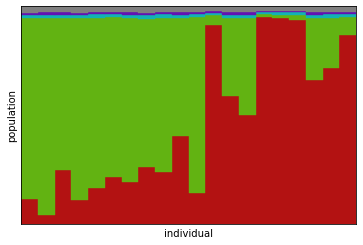

In [19]:
e_ind_admix = plotting_utils.get_vb_expectations(vb_params_dict, gh_loc, gh_weights)[0]

fig, axarr = plt.subplots(1, 1)
plotting_utils.plot_top_clusters(e_ind_admix, axarr, n_top_clusters = 4);

plt.ylabel('population')
plt.xlabel('individual')

# Optimize

In [20]:
vb_opt_dict, vb_opt, out, precond_objective, lbfgs_time = \
    s_optim_lib.run_preconditioned_lbfgs(g_obs, 
                        vb_params_dict, 
                        vb_params_paragami,
                        prior_params_dict,
                        gh_loc, gh_weights)

compiling preconditioned objective ... 
done. Elasped: 41.8594
init kl: 1833.881224
iteration [16]; kl:1833.668465; elapsed: 0.697secs
lbfgs converged successfully
done. Elapsed 1.9338


# Check out the fit

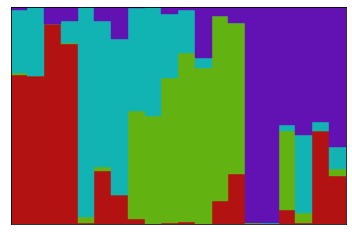

In [21]:
# truth 
fig, axarr = plt.subplots(1, 1)
plotting_utils.plot_admixture(true_ind_admix_propn, axarr);

Text(0.5, 0, 'individual')

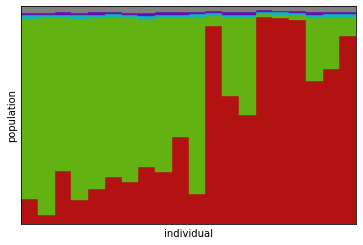

In [23]:
# estimated 
e_ind_admix = plotting_utils.get_vb_expectations(vb_opt_dict, gh_loc, gh_weights)[0]

fig, axarr = plt.subplots(1, 1)
plotting_utils.plot_top_clusters(e_ind_admix, axarr, n_top_clusters = 4);

plt.ylabel('population')
plt.xlabel('individual')

# Define sensitivity object

In [24]:
# initial prior alpha
use_free_alpha = True
prior_alpha0 = prior_params_paragami['dp_prior_alpha'].flatten(prior_params_dict['dp_prior_alpha'], 
                                                              free = use_free_alpha)

In [25]:
# set up objective as function of vb params and prior param 

_hyper_par_objective_fun = lambda vb_params, prior_params : \
    structure_model_lib.alpha_objective_fun(vb_params, 
                                            prior_params, 
                                            gh_loc, 
                                            gh_weights)
    
hyper_par_objective_fun = paragami.FlattenFunctionInput(
                                original_fun=_hyper_par_objective_fun, 
                                patterns = [vb_params_paragami, prior_params_paragami['dp_prior_alpha']],
                                free = [True, True],
                                argnums = [0, 1])

### Set up hessian solver

In [27]:
# define preconditioner
cg_precond = lambda v : get_mfvb_cov_matmul(v, vb_opt_dict,
                                            vb_params_paragami,
                                            return_info = True)

In [28]:
alpha0 = prior_params_dict['dp_prior_alpha']
alpha_free = prior_params_paragami['dp_prior_alpha'].flatten(alpha0, 
                                                              free = True)

vb_sens = HyperparameterSensitivityLinearApproximation(
                    objective_fun = precond_objective.f, 
                    opt_par_value = vb_opt, 
                    hyper_par_value0 = alpha_free, 
                    obj_fun_hvp = precond_objective.hvp, 
                    hyper_par_objective_fun = hyper_par_objective_fun, 
                    cg_precond = cg_precond)

NOTE custom hvp
Compiling hessian solver ...
Hessian solver compile time: 75.2936sec

Compiling cross hessian...
Cross-hessian compile time: 0.274538sec

LR sensitivity time: 0.211886sec



# Perturb alpha. Check results

In [32]:
# set new alpha 
new_alpha = np.array([5.])

prior_params_pert_dict = deepcopy(prior_params_dict)
prior_params_pert_dict['dp_prior_alpha'] = new_alpha


In [33]:
print('initial alpha, ', prior_params_dict['dp_prior_alpha'])
print('perturbed alpha, ', prior_params_pert_dict['dp_prior_alpha'])


initial alpha,  [3.]
perturbed alpha,  [5.]


In [34]:
# linear response prediction 
lr_vb_free_params = \
    vb_sens.predict_opt_par_from_hyper_par(
        prior_params_paragami['dp_prior_alpha'].flatten(prior_params_pert_dict['dp_prior_alpha'], 
                                                        free = use_free_alpha))

print('l_inf diff: ', np.max(np.abs(lr_vb_free_params - vb_opt)))


l_inf diff:  0.6935223348056967


In [35]:
(lr_vb_free_params**2).mean()

DeviceArray(1.10730134, dtype=float64)

### reoptimize

In [36]:
new_init_dict = deepcopy(vb_opt_dict)

In [37]:
vb_pert_dict, vb_opt_pert = \
    s_optim_lib.run_preconditioned_lbfgs(g_obs, 
                        new_init_dict, 
                        vb_params_paragami,
                        prior_params_pert_dict,
                        gh_loc, gh_weights)[0:2]

compiling preconditioned objective ... 
done. Elasped: 40.3775
init kl: 2122.343332
iteration [20]; kl:2068.086352; elapsed: 0.804secs
iteration [27]; kl:2068.086152; elapsed: 0.348secs
lbfgs converged successfully
done. Elapsed 1.6651


### compare

In [38]:
def print_diff_plot(lr_vb_free_params, vb_opt_pert, vb_opt): 
    plt.plot(lr_vb_free_params - vb_opt, 
             vb_opt_pert - vb_opt, 
             '+', color = 'red')

    plt.plot(lr_vb_free_params - vb_opt, 
            lr_vb_free_params - vb_opt, 
             '-', color = 'blue')

    plt.xlabel('lr')
    plt.ylabel('re-optimized')


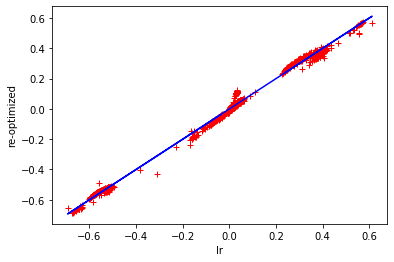

In [39]:
# compare free parameters
print_diff_plot(lr_vb_free_params, vb_opt_pert, vb_opt)

In [42]:
key = jax.random.PRNGKey(1)

def get_e_num_pred_clusters(vb_params_dict): 
    
    stick_means = vb_params_dict['ind_admix_params']['stick_means']
    stick_infos = vb_params_dict['ind_admix_params']['stick_infos']
    
    return structure_model_lib.get_e_num_pred_clusters(stick_means, stick_infos, gh_loc, gh_weights, 
                                                            key = key, n_samples = 100)

In [43]:
print('init number of cluster: ', get_e_num_pred_clusters(vb_opt_dict))
print('pert number of cluster: ', get_e_num_pred_clusters(vb_pert_dict))
print('lr number of cluster: ', get_e_num_pred_clusters(vb_params_paragami.fold(lr_vb_free_params, 
                                                                                free = True)))

init number of cluster:  2.9463801674446235
pert number of cluster:  3.720842183627228
lr number of cluster:  3.6916182712858494


# Fit for a range of alpha

In [44]:
alpha_list = np.arange(1, 8)

In [47]:
def refit_with_alpha(alpha, new_init_dict):
    # sets new alpha, returns new vb optimum
    
    # set new prior
    new_alpha = np.array([alpha])

    prior_params_pert_dict = deepcopy(prior_params_dict)
    prior_params_pert_dict['dp_prior_alpha'] = new_alpha
    
    # set new objective 
    vb_opt_pert = \
        s_optim_lib.run_preconditioned_lbfgs(g_obs, 
                        new_init_dict, 
                        vb_params_paragami,
                        prior_params_pert_dict,
                        gh_loc, gh_weights)[1]
        
    return vb_opt_pert


In [48]:
print('alphas: ', alpha_list)

alphas:  [1 2 3 4 5 6 7]


In [49]:
vb_pert_list = []
for alpha in alpha_list: 
    print('\n re-optimzing with alpha = ', alpha)
    
    vb_pert_list.append(refit_with_alpha(alpha, new_init_dict))



 re-optimzing with alpha =  1
compiling preconditioned objective ... 
done. Elasped: 40.9091
init kl: 1544.993598
iteration [20]; kl:1415.597841; elapsed: 0.881secs
iteration [36]; kl:1415.574740; elapsed: 0.760secs
lbfgs converged successfully
done. Elapsed 2.1303

 re-optimzing with alpha =  2
compiling preconditioned objective ... 
done. Elasped: 40.4681
init kl: 1689.331031
iteration [20]; kl:1666.490170; elapsed: 0.805secs
iteration [26]; kl:1666.490055; elapsed: 0.348secs
lbfgs converged successfully
done. Elapsed 1.6424

 re-optimzing with alpha =  3
compiling preconditioned objective ... 
done. Elasped: 40.842
init kl: 1833.668465
iteration [1]; kl:1833.668464; elapsed: 0.121secs
lbfgs converged successfully
done. Elapsed 0.604

 re-optimzing with alpha =  4
compiling preconditioned objective ... 
done. Elasped: 40.911
init kl: 1978.005899
iteration [20]; kl:1962.530079; elapsed: 0.836secs
iteration [22]; kl:1962.530071; elapsed: 0.158secs
lbfgs converged successfully
done. El

# Check free parameters

In [50]:
lr_list = []

for alpha in alpha_list: 
    
    # set alpha 
    new_alpha = np.array([alpha])
    prior_params_pert_dict = deepcopy(prior_params_dict)
    prior_params_pert_dict['dp_prior_alpha'] = new_alpha
    
    # get linear response
    lr_list.append(vb_sens.predict_opt_par_from_hyper_par(
        prior_params_paragami['dp_prior_alpha'].flatten(prior_params_pert_dict['dp_prior_alpha'], 
                                                        free = use_free_alpha)))


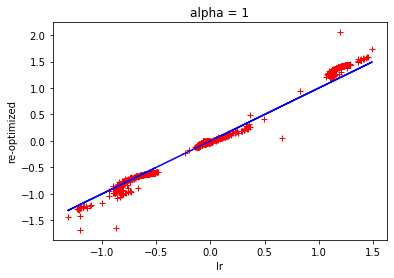

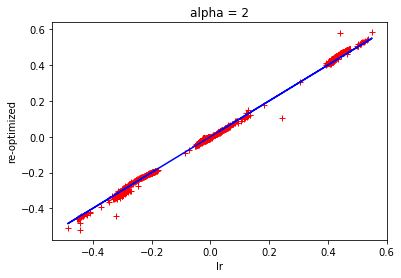

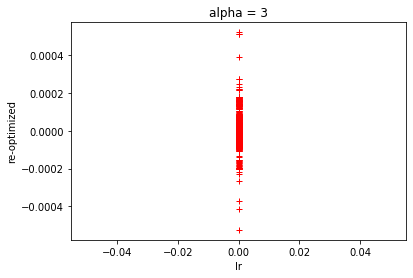

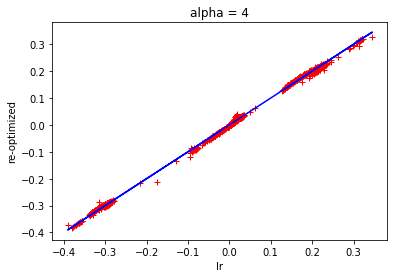

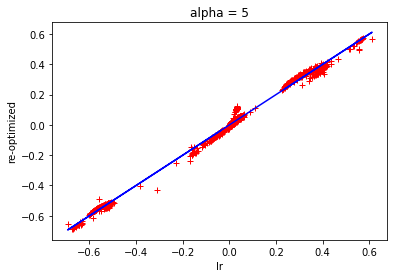

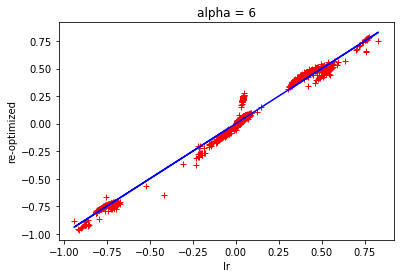

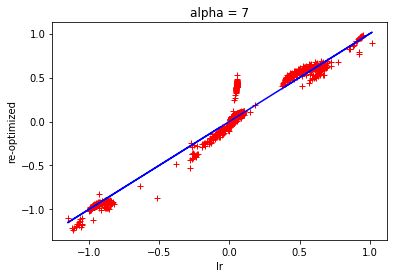

In [51]:
for i in range(len(alpha_list)): 
    plt.figure()
    print_diff_plot(lr_list[i], vb_pert_list[i], vb_opt)
    
    plt.title('alpha = {}'.format(alpha_list[i]))


# Number of clusters

In [52]:
import numpy as onp

In [55]:
lr_e_num_clusters_vec = onp.zeros(len(alpha_list))
refit_e_num_clusters_vec = onp.zeros(len(alpha_list))

for i in range(len(alpha_list)): 
    
    # get dictionaries
    pert_dict = vb_params_paragami.fold(vb_pert_list[i], free = True)
    lr_dict = vb_params_paragami.fold(lr_list[i], free = True)
        
    # get number of clusters
    refit_e_num_clusters_vec[i] = get_e_num_pred_clusters(pert_dict)
    lr_e_num_clusters_vec[i] = get_e_num_pred_clusters(lr_dict)


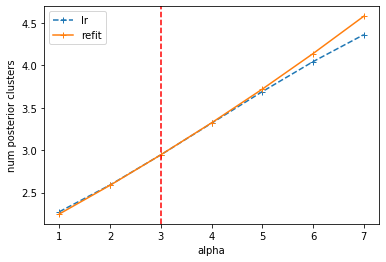

In [56]:
plt.plot(alpha_list, lr_e_num_clusters_vec, '+--')
plt.plot(alpha_list, refit_e_num_clusters_vec, '+-')

plt.xlabel('alpha')
plt.ylabel('num posterior clusters')
plt.legend(('lr', 'refit'))

plt.axvline(prior_params_dict['dp_prior_alpha'], color = 'red', linestyle = 'dashed')